## libs

In [1]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
import matplotlib.pylab as plab

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate
from pathlib import Path
from tqdm import tqdm

## initialization

In [2]:
STARS_DIRECTORY = Path('../sessions/')
ISOCHRONES_DIRECTORY = Path ('../isochrones/')
MAIN_DIRECTORY = Path('../')

In [3]:
def get_stars_with_mass(table, name):
    
    main_component = pd.DataFrame(columns=table.columns, index=[0])
    
    for M_1 in table.columns:
        stars = pd.DataFrame(data={'q' : table.index})
        stars['M_2'] = float(M_1) * stars['q']
        
        stars['G_2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_2'])
        stars['BP_2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_2']) 
        stars['RP_2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_2'])

        G_1 = interp(isochrone['Mini'], isochrone['Gmag'], M_1)
        BP_1 = interp(isochrone['Mini'], isochrone["G_BPmag"], M_1) 
        RP_1 = interp(isochrone['Mini'], isochrone["G_RPmag"], M_1)

        stars['G, mag'] = stars['G_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['G_2, mag'] - G_1))
        stars['BP-RP, mag'] = (stars['BP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['BP_2, mag'] - BP_1)) -
                              (stars['RP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['RP_2, mag'] - RP_1))))


        if name == 'g':
            table[M_1] = stars['G, mag'].tolist()
            main_component[M_1] = G_1

        elif name == 'color':
            table[M_1] = stars['BP-RP, mag'].tolist()
            main_component[M_1]= BP_1 - RP_1
        else:
            raise ValueError('wrong name') 

    table = main_component.append(table, ignore_index=False)
    return table


def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

def gauss(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

In [231]:
CLUSTER = 'NGC_2281'

In [233]:
clusters_list = pd.read_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx', index_col = 0)

In [234]:
stars = read_file(STARS_DIRECTORY / f'{CLUSTER}_selected_2')
isochrone = read_file(ISOCHRONES_DIRECTORY / f"{CLUSTER}_{clusters_list.loc[CLUSTER,'Age']}.txt")
isochrone = isochrone[isochrone['G_BPmag'] - isochrone['G_RPmag'] > 0]

stars['bp-rp'] = stars['phot_bp_mean_mag'] - stars['phot_rp_mean_mag']

In [235]:
mask = ((stars['bp-rp'] > 0.3 + 1.33104 * clusters_list.loc[CLUSTER,'E(B-V)']) & 
        (stars['bp-rp'] < 0.963 + 1.33104 * clusters_list.loc[CLUSTER,'E(B-V)']))
stars = stars[mask]

In [239]:
stars.reset_index(inplace=True)

## qM coordinates grid

In [232]:
q_array = np.linspace(0.102, 1, 101)
M_array = np.geomspace(0.884, 1.7, 151)

g_table = pd.DataFrame(columns = M_array, index=q_array)
color_table = pd.DataFrame(columns = M_array, index=q_array)

In [236]:
g_table = get_stars_with_mass(g_table, 'g')
color_table = get_stars_with_mass(color_table, 'color')

In [237]:
g_table -= (5 - 5 * np.log10(clusters_list.loc[CLUSTER,'Distance']) 
            - 2.749632 * (clusters_list.loc[CLUSTER, 'E(B-V)']))
color_table += 1.33104 * clusters_list.loc[CLUSTER,'E(B-V)']

## new coordinates definition

In [238]:
M_1 = np.ndarray((len(stars+1)))
q = np.ndarray((len(stars+1)))

In [240]:
for i in tqdm(range(len(stars))):
    g = stars.loc[i,'phot_g_mean_mag']
    color = stars.loc[i,'bp-rp']

    g_difference = (g_table - g) * (g_table - g)
    color_difference = (color_table - color) * (color_table - color)
    
    distance = g_difference + color_difference
    M_1[i] = distance.min().idxmin()
    q[i] = distance[M_1[i]].idxmin()

100%|██████████| 99/99 [00:14<00:00,  7.42it/s]


In [241]:
stars['M_1_detected'] = M_1
stars['q_detected'] = q
stars['M_2_detected'] = M_1 * q

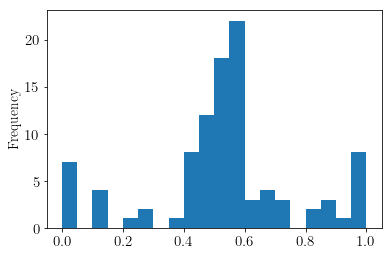

In [242]:
stars['q_detected'].plot.hist(20)

## from qM to magnitudes transition

In [243]:
stars['G1_after'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_1_detected'])
stars['BP1_after'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_1_detected']) 
stars['RP1_after'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_1_detected'])


stars['G2_after'] = 0
stars['BP2_after'] = 0
stars['RP2_after'] = 0

mask = (stars['q_detected'] > 0)
stars.loc[stars[mask].index,'G2_after'] = interp(isochrone['Mini'], isochrone['Gmag'],
                                                 stars.loc[stars[mask].index,'M_2_detected'])
stars.loc[stars[mask].index,'BP2_after'] = interp(isochrone['Mini'], isochrone['G_BPmag'],
                                                 stars.loc[stars[mask].index,'M_2_detected'])
stars.loc[stars[mask].index,'RP2_after'] = interp(isochrone['Mini'], isochrone['G_RPmag'],
                                                 stars.loc[stars[mask].index,'M_2_detected'])

In [244]:
stars['G_after'] = stars['G1_after'] - 2.5 * np.log10(1+ pow(2.512, stars['G1_after'] - stars['G2_after']))
stars['BP-RP_after'] = (stars['BP1_after'] -
                          2.5 *np.log10(1 + pow(2.512, stars['BP1_after'] - stars['BP2_after'])) -
                          (stars['RP1_after'] - 2.5 *np.log10(1+ pow(2.512, stars['RP1_after'] - 
                           stars['RP2_after']))))

mask_singles = (stars['q_detected'] == 0)
stars.loc[stars[mask_singles].index,'G_after']  = stars.loc[stars[mask_singles].index,'G1_after']
stars.loc[stars[mask_singles].index,'BP-RP_after']  = (stars.loc[stars[mask_singles].index,'BP1_after'] -
                                                       stars.loc[stars[mask_singles].index,'RP1_after'])

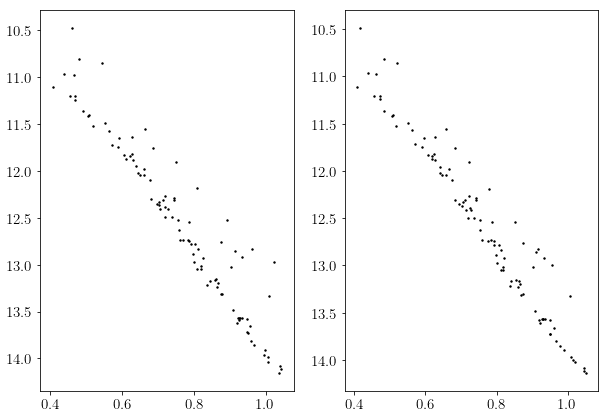

In [245]:
fig, ax = plt.subplots(figsize=(10,7))

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')


plt.subplot(1, 2, 1)
plt.scatter (stars['bp-rp'],
            stars['phot_g_mean_mag'],
            c='black', s=2, zorder=100)
plt.gca().invert_yaxis()



plt.subplot(1, 2, 2)
plt.scatter (stars['BP-RP_after']+1.33104 * clusters_list.loc[CLUSTER,'E(B-V)'],
            stars['G_after'] - (5 - 5 * np.log10(clusters_list.loc[CLUSTER,'Distance']) 
            - 2.749632 * (clusters_list.loc[CLUSTER, 'E(B-V)'])),
            c='black', s=2, zorder=100)

plt.gca().invert_yaxis()

ax.grid(c='#aaaaaa', ls='--')

#plt.yticks(np.arange(6,19, step=1.0))
#plt.xticks(np.arange(-0.5, 3, step=0.5))

ax.tick_params(axis='both', which='major')

#ax.legend(loc='upper right')
#plt.savefig(MODEL_DIRECTORY / (f"model_{LOG_AGE}.pdf"), bbox_inches = 'tight')